# Normalization
There are several popular methods for normalizing data and infinitely many fine-tuned techniques for special cases. Here we will explore the following strategies:
* Probability Density (PDF)
* Scaling to A Range
* Log Scaling
* Z-Score
* Re-Classifying to $dPrice$

The first two will involve modifying range of stock prices. Within the last we will modify our comparison entirely; instead of comparing stock prices we will only compare _changes_ in price.

This notebook will be setup to search for the closest period Q to a randomly selected period P using each strategy.

Text(0, 0.5, 'Day Close (USD)')

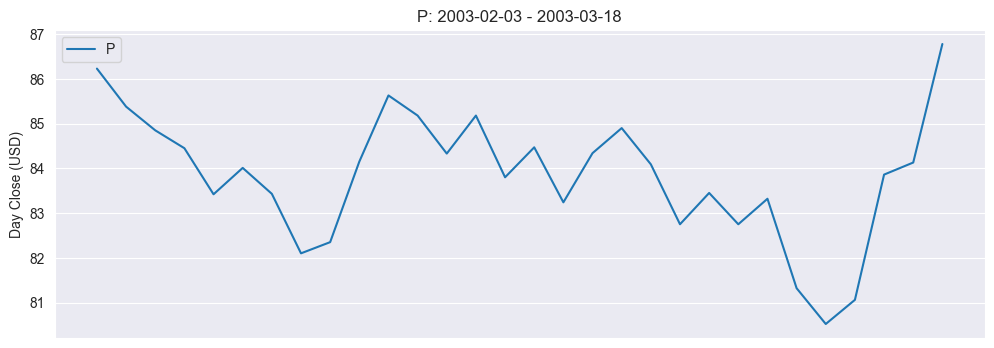

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
# I have no idea what I'm doing:
pd.options.mode.chained_assignment = None

# The constants we will be working with:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0)) * 100_000

spy = pd.read_csv('../data/SPY.csv', parse_dates=True)

p_duration= 30
p_start = random.randint(0, len(spy) - p_duration)

# Get our random period and other periods.
# TODO: There is definitely some overlap in q and p that should not exist
p = spy.iloc[p_start : p_start + p_duration]
q_rangeA = [spy.iloc[i:i+p_duration] for i in range(0, p_start, p_duration)]
q_rangeB = [spy.iloc[p_start + p_duration : i + p_start + p_duration] for i in range(p_start + p_duration, len(spy), p_duration)]

# Ensure we don't have any straggler ranges.
all_q = [q for q in q_rangeA + q_rangeB if len(q) == p_duration]

plt.figure(figsize=(12, 4))
plt.title(f'P: {spy.iloc[p_start]["Date"]} - {spy.iloc[p_start + p_duration]["Date"]}')
sns.lineplot(data=p, x="Date", y='Close', label='P')
plt.xticks([])
plt.xlabel('')
plt.ylabel('Day Close (USD)')

In [46]:
# Normalization Techniques
def normalize_pdf(data):
    return data / data.sum()

def normalize_range_scale(data):
    return (data - (data.min()) + 0.001) / (data.max() - data.min())

def normalize_log(data):
    return np.log(data)

def normalize_zscore(data):
    return (data - np.mean(data)) / np.std(data)

def normalize_dprice(data):
    return data.pct_change(-1)

In [47]:
# Normalize and Prepare Data
p.reset_index(inplace=True)
p['NormClose'] = normalize_pdf(p['Close'])
p['NormRange'] = normalize_range_scale(p['Close'])
p['NormLog'] = normalize_log(p['Close'])
p['NormZScore'] = normalize_zscore(p['Close'])
p['NormDPrice'] = normalize_dprice(p['Close'])

for period in all_q:
    period.reset_index(inplace=True)
    period['NormClose'] = normalize_pdf(period['Close'])
    period['NormRange'] = normalize_range_scale(period['Close'])
    period['NormLog'] = normalize_log(period['Close'])
    period['NormZScore'] = normalize_zscore(period['Close'])
    period['NormDPrice'] = normalize_dprice(period['Close'])

/Users/peterv/PycharmProjects/DejaVu/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 1200x400 with 0 Axes>

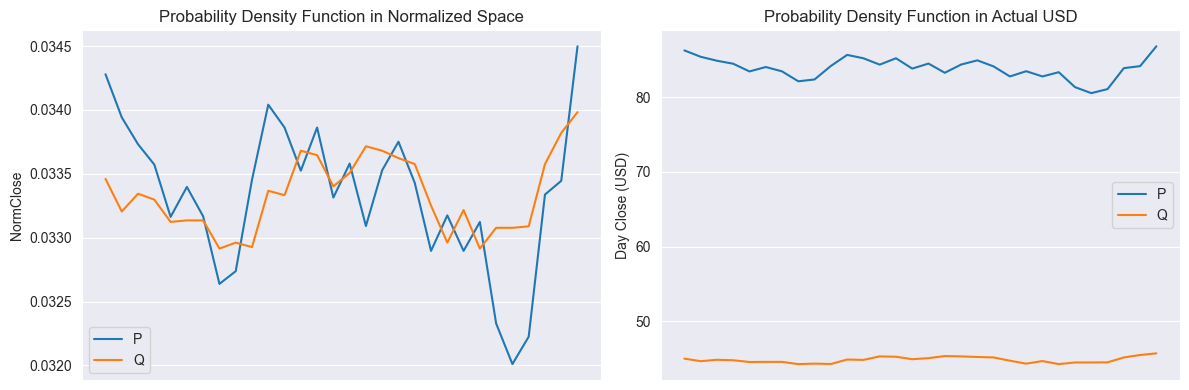

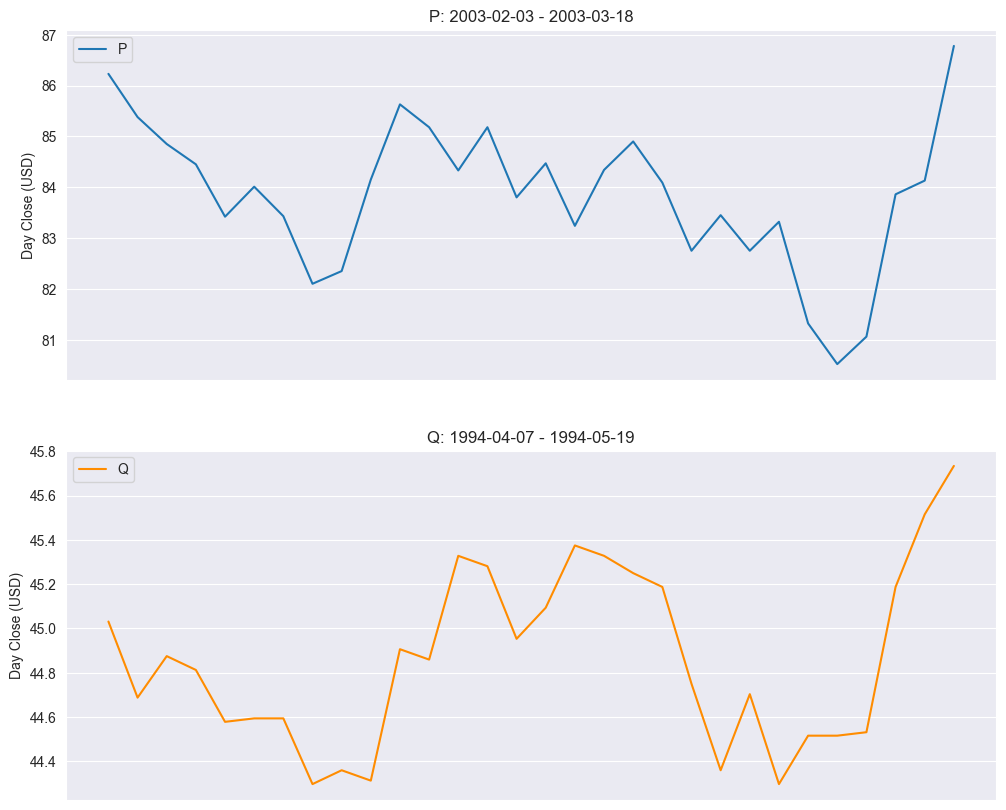

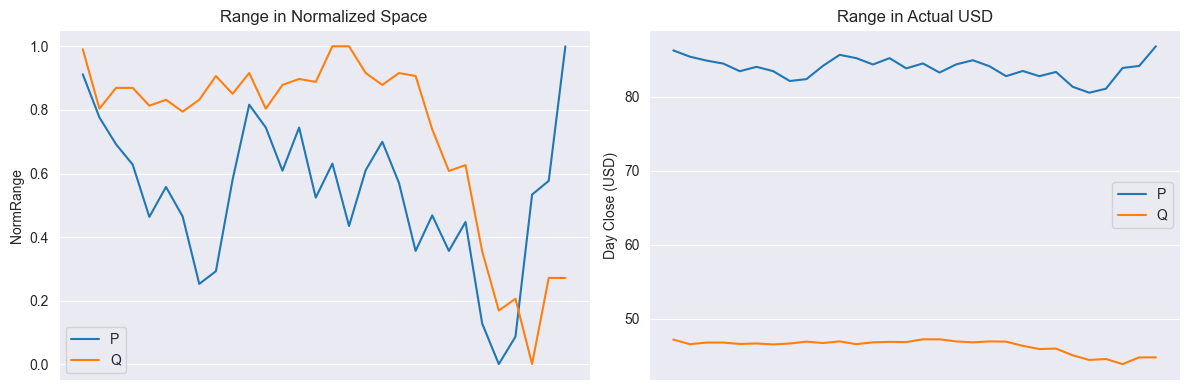

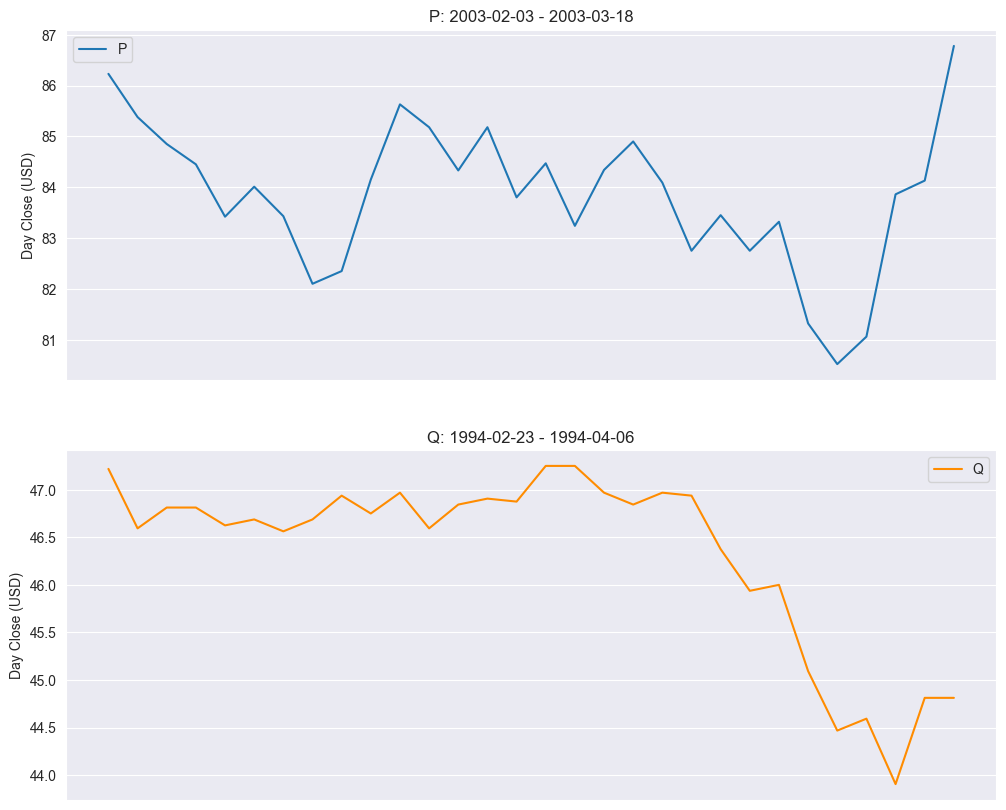

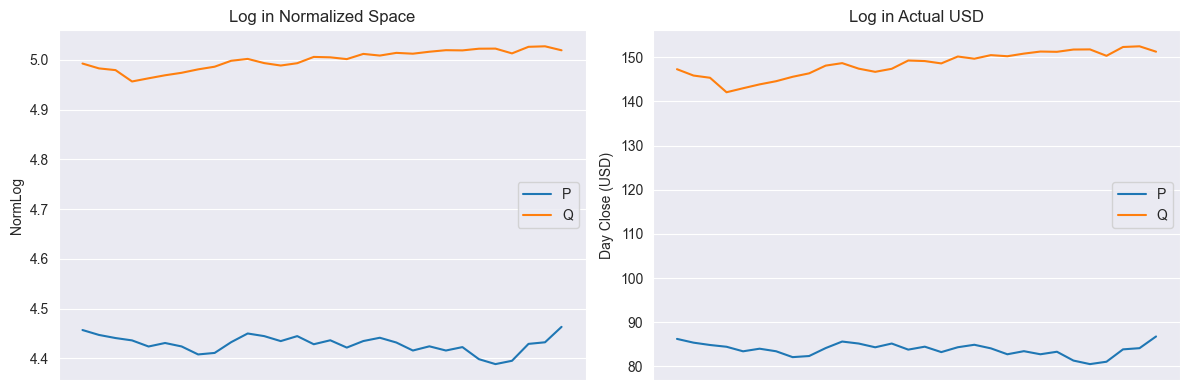

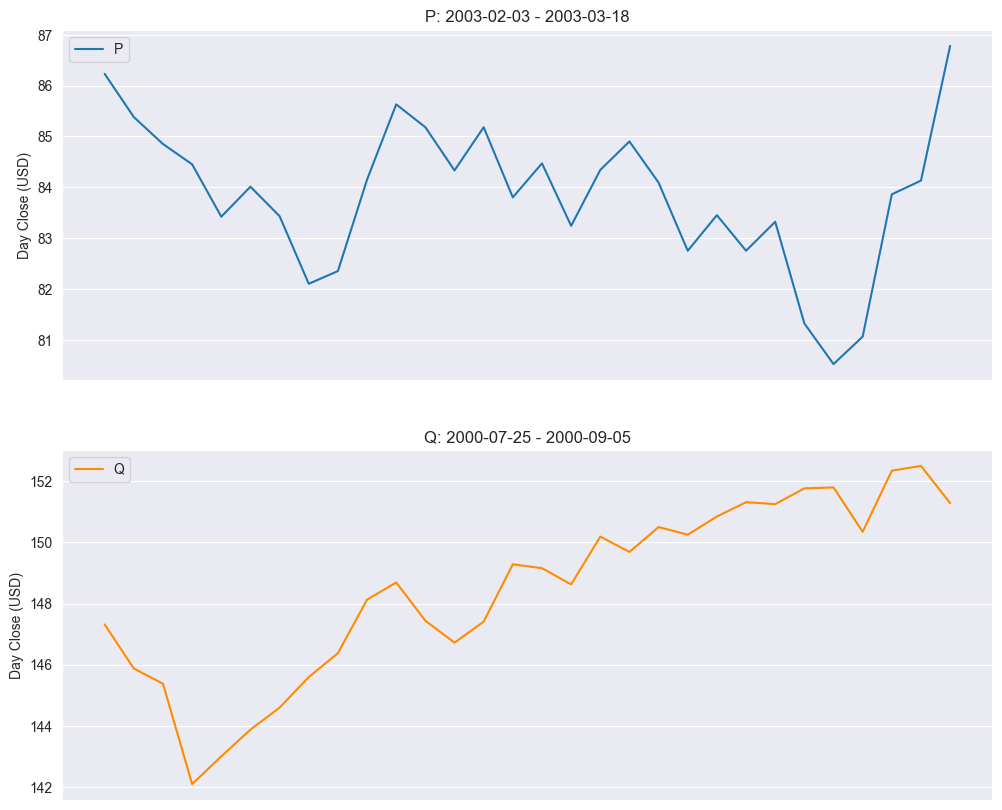

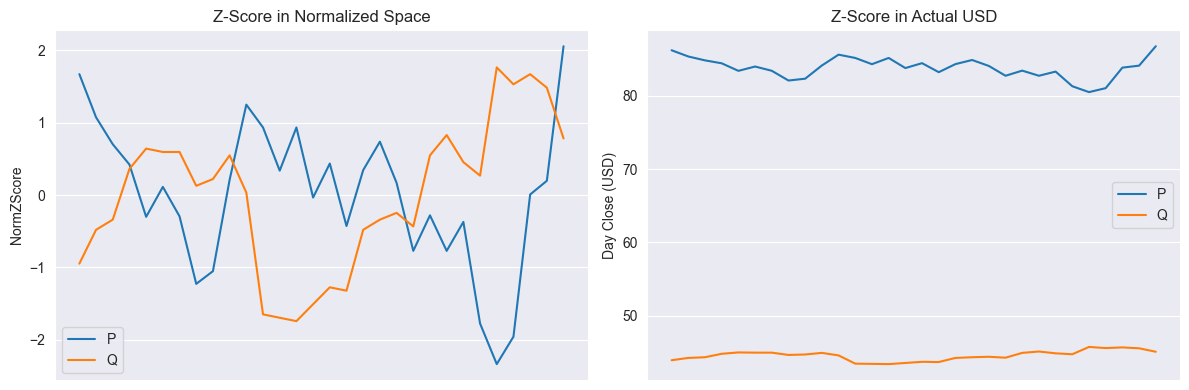

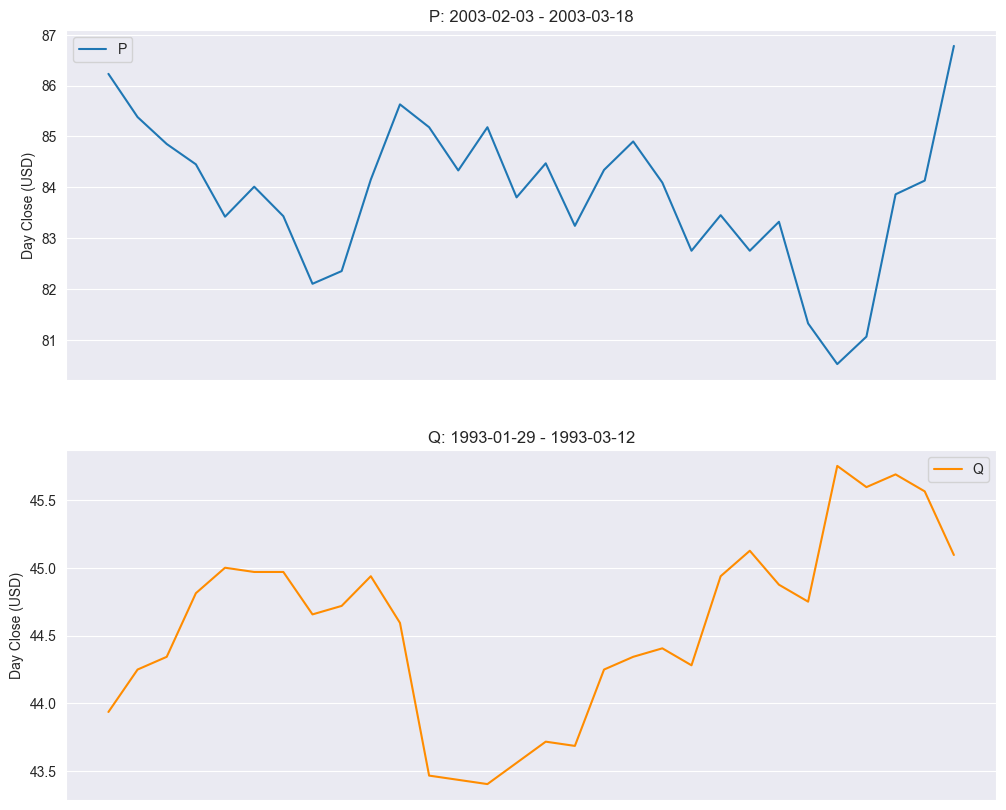

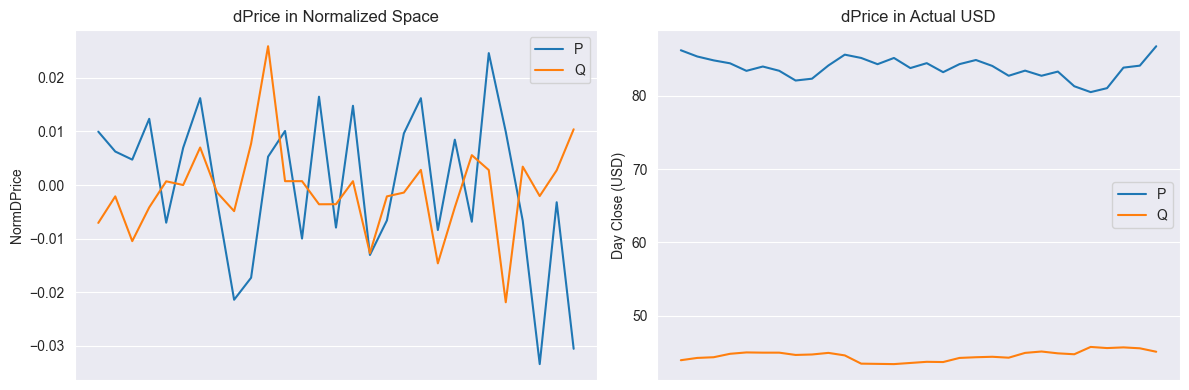

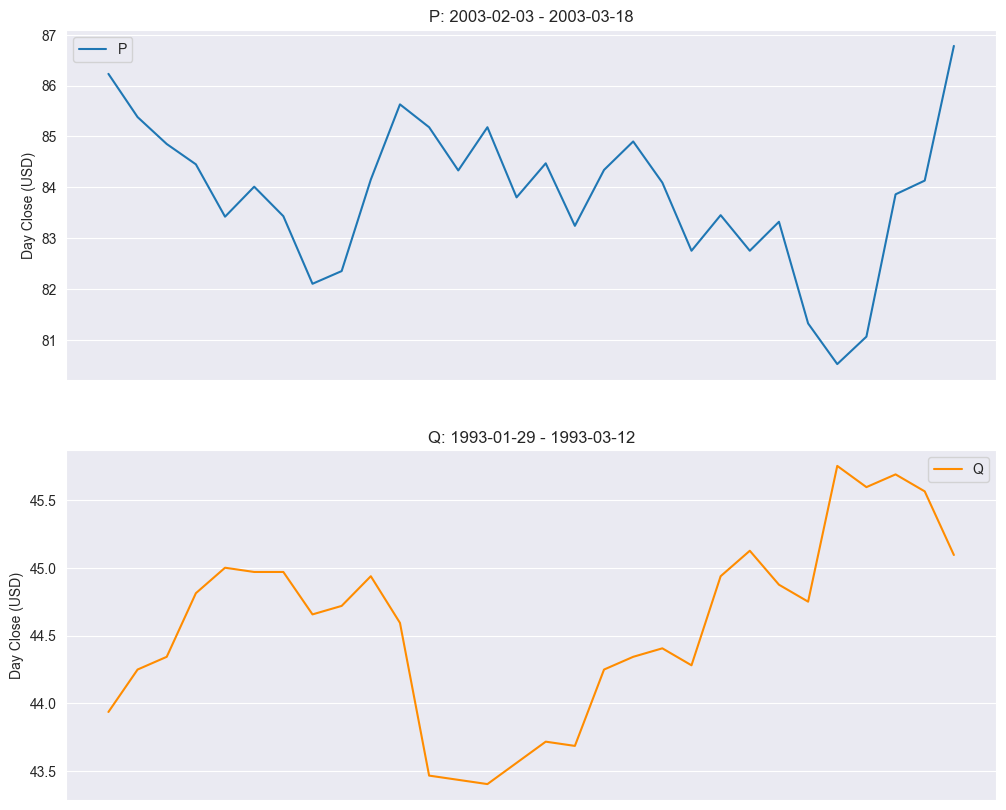

In [48]:
# Fetch the best matches in each category.
best_matches = {
    'Probability Density Function': min(all_q, key=lambda q: kl_divergence(p['NormClose'], q['NormClose'])),
    'Range': min(all_q, key=lambda q: kl_divergence(p['NormRange'], q['NormRange'])),
    'Log': min(all_q, key=lambda q: kl_divergence(p['NormLog'], q['NormLog'])),
    'Z-Score': min(all_q, key=lambda q: kl_divergence(p['NormZScore'], q['NormZScore'])),
    'dPrice': min(all_q, key=lambda q: kl_divergence(p['NormDPrice'], q['NormDPrice'])),
}
strats = ['NormClose', 'NormRange', 'NormLog', 'NormZScore', 'NormDPrice']

# Plot the best matches.
plt.figure(figsize=(12, 4))
for (key, value), strat in zip(best_matches.items(), strats):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'{key} in Normalized Space')
    sns.lineplot(data=p, x=p.index, y=f'{strat}', label='P')
    sns.lineplot(data=value, x=value.index, y=f'{strat}', label='Q')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel(f'{strat}')
    plt.subplot(1, 2, 2)
    plt.title(f'{key} in Actual USD')
    sns.lineplot(data=p, x=p.index, y='Close', label='P')
    sns.lineplot(data=value, x=value.index, y='Close', label='Q')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.title(f'P: {spy.iloc[p_start]["Date"]} - {spy.iloc[p_start + p_duration]["Date"]}')
    sns.lineplot(data=p, x="Date", y='Close', label='P')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')
    plt.subplot(2, 1, 2)
    plt.title(f"Q: {value.iloc[0]['Date']} - {value.iloc[-1]['Date']}")
    sns.lineplot(data=value, x="Date", y='Close', label='Q', color='darkorange')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('Day Close (USD)')

# Observations

(Until we compare the charts in their own scales... what we see is pretty useless